<a href="https://www.kaggle.com/code/utkarshx27/icr-eda-and-lr-model?scriptVersionId=134208838" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="padding: 40px;color:white;margin:10;font-size:90%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>ICR - Identifying Age-Related Conditions <br> Use Machine Learning to detect conditions with measurements of anonymous characteristics </span></b> </div>
***

In [17]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


# <h1 style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Import necessary libraries</span></b> </h1>

In [38]:
import math
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from catboost import CatBoostRegressor as cbr
from lightgbm import LGBMRegressor as lgbmr
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

In [19]:
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
sample_submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')

# <h1 style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Data Overview</span></b> </h1>

In [20]:
train.head(3)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0


In [21]:
train.shape, test.shape

((617, 58), (5, 57))

In [22]:
def summary(df):
    print(f'data shape: {df.shape}')  
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['missing'] = df.isnull().sum().values 
    summ['missing[%]'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values

    return summ

# <h1 style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Data Summary</span></b> </h1>

In [23]:
summary(train)

data shape: (617, 58)


,data type,missing,missing[%],#unique,min,max
Id,object,0,0.000000,617,NaN,NaN
AB,float64,0,0.000000,217,0.081187,6.161666
AF,float64,0,0.000000,599,192.59328,28688.18766
AH,float64,0,0.000000,227,85.200147,1910.123198
AM,float64,0,0.000000,605,3.177522,630.51823
AR,float64,0,0.000000,130,8.138688,178.943634
AX,float64,0,0.000000,427,0.699861,38.27088
AY,float64,0,0.000000,148,0.025578,10.315851
AZ,float64,0,0.000000,484,3.396778,38.971568
BC,float64,0,0.000000,259,1.2299,1463.693448


# <h1 style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Outliars</span></b> </h1>

/tmp/ipykernel_32/2653694490.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


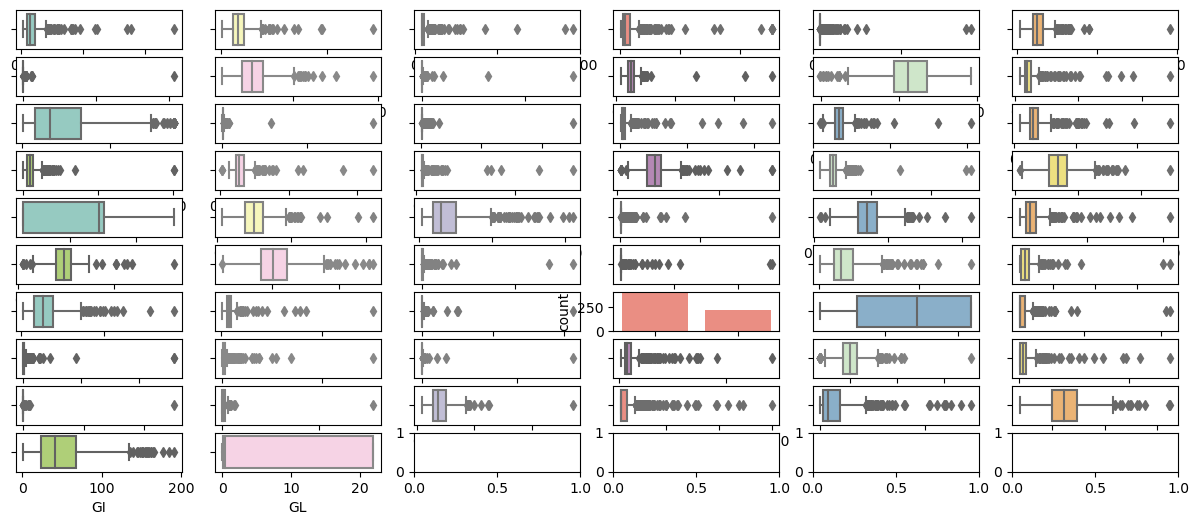

In [24]:
def boxplots(df):
    cols = df.columns[1:-1]
    n = (len(cols) - 1) // 6 + 1
    m = min(len(cols), 6)
    
    palette = sns.color_palette("Set3", len(cols))
    palette_colors = [tuple(palette[i]) for i in range(len(cols))]
    
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15, 6))
    for idx, col in enumerate(cols):
        i = idx // m
        j = idx % m
        if df[col].dtype == 'object':
            sns.countplot(data=df, x=col, ax=axes[i][j], palette=[palette_colors[idx]])
        else:
            sns.boxplot(data=df, x=col, ax=axes[i][j], palette=[palette_colors[idx]])
    
    plt.tight_layout()
    plt.show()
    
boxplots(train)

# <h1 style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Data Preprocessing</span></b> </h1>

In [25]:
def preprocessing(df):
    df = df.drop('Id', axis=1)
    df = df.dropna()
    
    categorical_cols = ["EJ"]
    encoder = OrdinalEncoder()
    df[categorical_cols] = encoder.fit_transform(df[categorical_cols])
    
    return df
train_cleaned = preprocessing(train)

# <h1 style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Correlation Matrix</span></b> </h1>

In [26]:
corr = train.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm')

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
AB,1.000000,0.350231,0.249246,0.530687,0.157712,0.471912,0.011004,0.158569,0.331736,0.278920,0.246410,0.412869,0.237270,0.148966,0.375898,0.081112,0.233556,0.437661,0.299386,0.426383,0.040467,-0.005741,0.158294,-0.066341,-0.109078,-0.183127,-0.050492,0.299234,-0.204446,0.343071,-0.137980,0.195190,0.059821,0.036950,0.016847,0.279021,0.058040,0.124917,0.072192,-0.023105,0.033086,-0.034322,0.290276,0.067027,0.041684,0.004967,0.169934,0.017990,0.036913,0.318741,0.003327,-0.017192,0.148456,0.002903,-0.061601,0.280612
AF,0.350231,1.000000,0.044140,0.183961,0.044917,0.248439,0.039417,0.219172,0.058831,0.045430,0.131428,0.241027,0.309300,0.018409,0.067106,0.013128,0.091546,0.181395,0.066975,0.126804,-0.030457,-0.035850,0.054071,0.132456,-0.118106,-0.127525,-0.113353,0.080841,-0.027899,0.330857,0.057947,0.255259,0.110287,-0.018922,-0.006084,0.141196,-0.045524,0.096498,0.116330,0.114897,-0.052378,-0.001646,0.060819,0.088511,0.080458,0.021914,0.148289,0.021009,-0.003108,0.079993,0.076449,-0.159796,0.187105,0.140935,-0.127870,0.302638
AH,0.249246,0.044140,1.000000,0.128268,0.749794,0.039324,0.055385,0.095627,0.366910,0.209508,0.055154,0.223916,0.131165,0.011948,0.440221,0.077926,0.162371,0.131419,0.164696,0.677612,0.693637,-0.018642,0.632552,0.070736,0.062493,0.260513,0.143512,0.105094,0.109871,0.148272,-0.050009,-0.026802,-0.032162,0.746715,0.002736,0.705110,0.175891,0.027994,-0.023344,-0.067320,0.678742,-0.010162,0.217062,-0.010942,-0.006100,0.035902,-0.022822,-0.009112,0.018328,0.159666,0.011332,-0.029422,-0.037542,-0.073142,0.029175,0.044645
AM,0.530687,0.183961,0.128268,1.000000,0.175212,0.225382,0.081666,0.131885,0.329658,0.277908,0.158404,0.178260,0.260038,0.011272,0.333209,0.004800,0.160961,0.249581,0.370031,0.250566,-0.029723,-0.026143,0.032254,0.001013,-0.031086,-0.255359,-0.062401,0.321732,-0.202972,0.347550,-0.091830,0.059895,0.038487,-0.036929,-0.040123,0.082645,-0.020696,0.043258,0.010132,0.055216,-0.042153,-0.019131,0.027564,0.002447,0.077170,-0.038974,0.187974,-0.009183,0.040846,0.217443,-0.012176,-0.019639,0.089008,0.100873,-0.079717,0.239170
AR,0.157712,0.044917,0.749794,0.175212,1.000000,0.011715,0.099947,0.099282,0.073730,-0.002509,0.048671,0.177579,0.184149,0.007044,0.137466,0.009110,-0.021310,0.020578,-0.002361,0.660409,0.745504,-0.153166,0.720853,0.108454,0.076620,0.281715,0.105616,0.301627,0.174468,0.318558,-0.010439,-0.028360,-0.006020,0.823012,-0.047274,0.741000,0.175292,0.027764,-0.009067,-0.051864,0.754615,0.014996,-0.006601,0.004419,0.028447,0.018049,0.080164,-0.007933,0.068271,0.002816,0.034682,0.027927,-0.120285,0.074428,0.028150,0.064380
AX,0.471912,0.248439,0.039324,0.225382,0.011715,1.000000,0.016315,0.269728,0.079799,0.124581,0.143351,0.428020,0.183762,0.038888,0.117972,0.016100,0.180710,0.247612,0.197018,0.176463,0.054424,-0.063454,0.092060,0.080091,-0.086019,-0.032053,0.043023,0.024006,-0.038901,0.183382,-0.015662,0.176643,-0.030058,0.024087,0.028683,0.110120,0.032320,0.158917,-0.030023,0.112591,-0.028936,-0.014398,0.173032,-0.031413,0.012873,0.114727,0.020747,-0.014095,0.045893,0.233188,0.099148,0.075500,0.119736,0.046596,-0.004384,0.097616
AY,0.011004,0.039417,0.055385,0.081666,0.099947,0.016315,1.000000,0.036790,0.132495,0.506917,0.042365,0.027618,0.116206,0.000098,0.118981,-0.008312,0.008158,0.028359,0.024272,0.150066,0.055311,-0.063460,0.030026,0.099241,0.068402,-0.054766,-0.019275,0.001266,-0.001491,0.138382,0.013437,-0.022305,-0.012687,0.064777,0.001053,0.083718,-0.030944,-0.007844,-0.010550,0.041698,0.077790,0.004263,-0.015492,-0.006392,-0.010587,0.357537,-0.027435,-0.002789,-0.010552,0.025665,0.002803,-0.006869,0.196392,0.022473,0.067403,0.082420
AZ,0.158569,0.219172,0.095627,0.131885,0.099282,0.269728,0.036790,1.000000,0.036424,0.135976,0.066121,0.140070,0.090152,0.023675,0.036973,0.007457,0.094239,-0.002935,0.095292,0.1655

# <h1 style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Distribution of Target Variable</span></b> </h1>

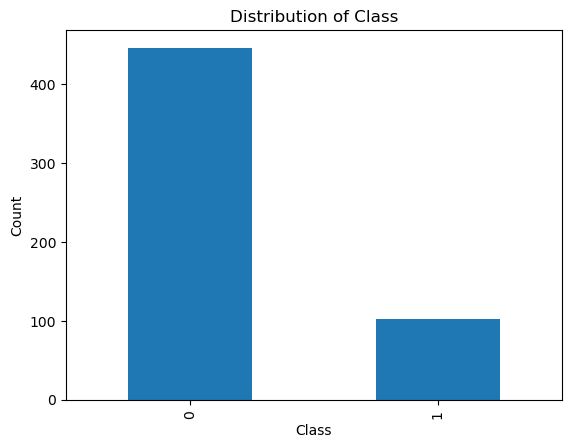

In [27]:
value_counts = train_cleaned['Class'].value_counts()
value_counts.plot(kind='bar')

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Class')

plt.show()

# <h1 style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Simple Logistic Regression Model</span></b> </h1>

In [28]:
X = train_cleaned.drop('Class', axis=1)
y = train_cleaned['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((438, 56), (110, 56), (438,), (110,))

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
def balanced_log_loss(y_true, y_pred):
    N0 = np.sum(y_true == 0)
    N1 = np.sum(y_true == 1)
    
    y0 = y_true == 0
    y1 = y_true == 1
    
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    log_loss = -np.sum(y0 * np.log(y_pred[:, 0]) + y1 * np.log(y_pred[:, 1]))
    log_loss /= N0 + N1
    
    return log_loss

param_dist = {
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [200, 400, 600, 800],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1]
}

xgb = XGBClassifier()

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, cv=3, scoring='roc_auc', n_iter=10)
random_search.fit(X_train_scaled, y_train)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

best_xgb = XGBClassifier(**best_params)
best_xgb.fit(X_train_scaled, y_train)

train_roc_score = roc_auc_score(y_train, best_xgb.predict_proba(X_train_scaled)[:, 1])
val_roc_score = roc_auc_score(y_test, best_xgb.predict_proba(X_test_scaled)[:, 1])
print("Train ROC score:", train_roc_score)
print("Validation ROC score:", val_roc_score)

y_val_pred = best_xgb.predict_proba(X_test_scaled)
log_loss = balanced_log_loss(y_test, y_val_pred)
print("Validation Balanced Log Loss:", log_loss)

Best Hyperparameters: {'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Train ROC score: 1.0
Validation ROC score: 0.9371980676328502
Validation Balanced Log Loss: 0.2924381602894176


# <h1 style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:14px;overflow:hidden;background-image: url(https://images.rawpixel.com/image_800/cHJpdmF0ZS9sci9pbWFnZXMvd2Vic2l0ZS8yMDIyLTA1L3Vwd2s2MTkxNjM4NC13aWtpbWVkaWEtaW1hZ2Uta293ZXdrYTYuanBn.jpg)"><b><span style='color:white'>Feature Importance</span></b> </h1>

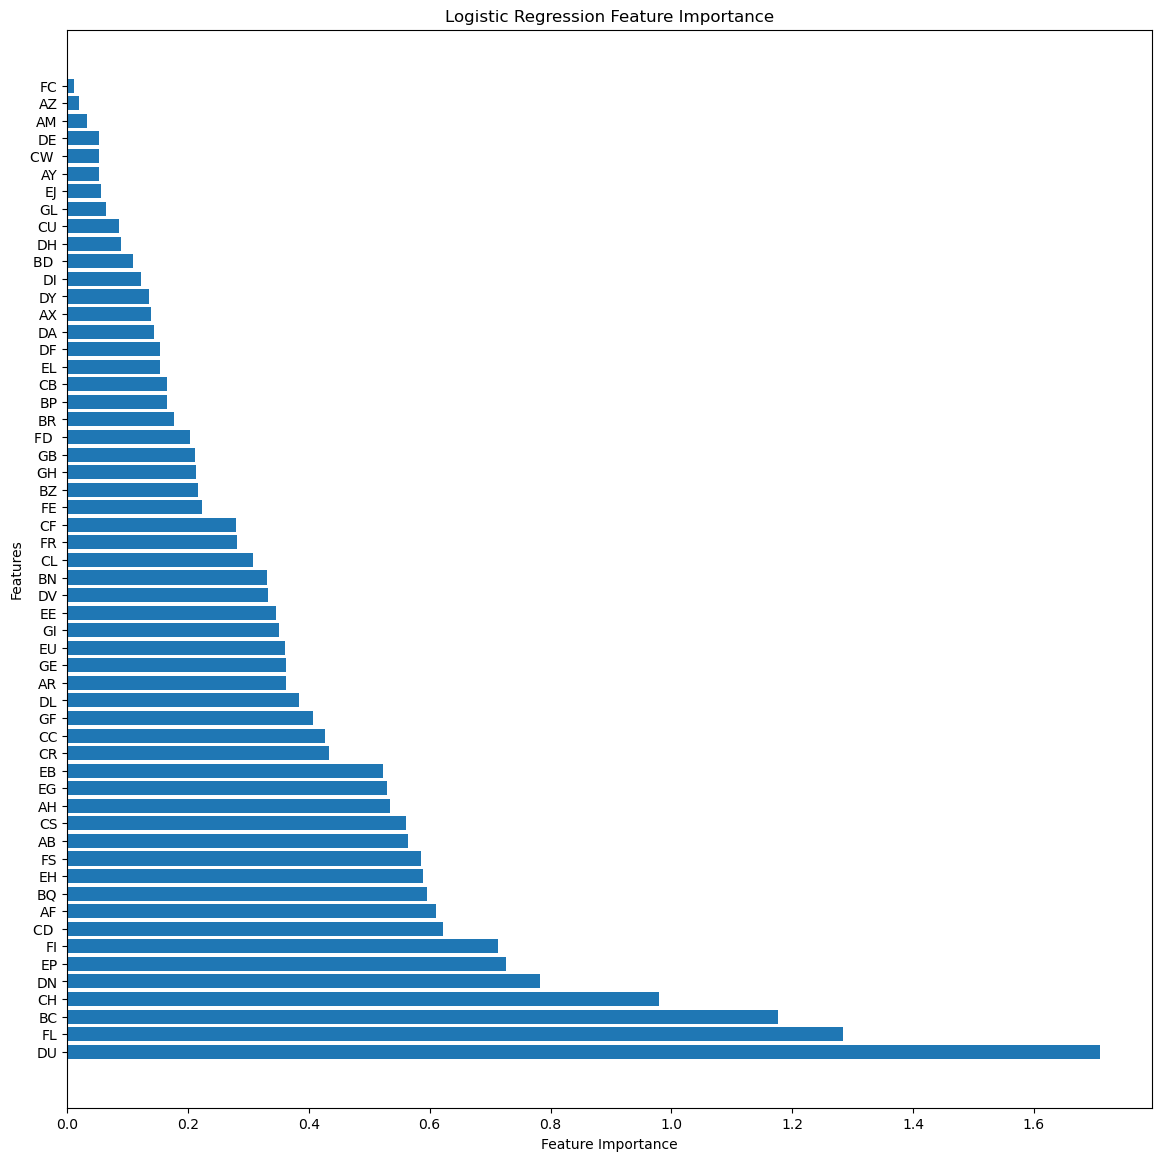

In [32]:
feature_importance = abs(lr.coef_[0])
feature_importance_dict = dict(zip(X_train.columns, feature_importance))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

features, importance = zip(*sorted_features)

plt.figure(figsize=(14, 14))
plt.barh(range(len(features)), importance, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Logistic Regression Feature Importance')
plt.show()